In [695]:
# Import Python modules

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [696]:
# Machine learning modules

from sklearn.model_selection import train_test_split 

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [697]:
# Filter methods

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest
from functools import partial


### Retrieve data from AACT

1. Use this link: [AACT Download](https://aact.ctti-clinicaltrials.org/download).
2. Select pipe-delimited files.
3. Download the latest version of the "Current Month's Daily Static Copies."

- You can find information about each table in the AACT dataset [here](https://aact.ctti-clinicaltrials.org/data_dictionary).



#### conditions.txt
- Name(s) of the disease(s) or condition(s) studied in the clinical study, or the focus of the clinical study. Can include NLM's Medical Subject Heading (MeSH)-controlled vocabulary terms.

In [698]:
# Read conditions file from AACT database
file_path = './AACT_20240125/conditions.txt'

# select only the nct_id, reason, and count columns
conditions = pd.read_csv(file_path, header=0, sep="|", usecols=[1,3])

# Display the DataFrame
conditions.head()

,nct_id,downcase_name
0,NCT05522114,tmd
1,NCT03533179,drug overdose
2,NCT05977569,fasting
3,NCT05976022,mdd
4,NCT04972968,polymyalgia rheumatica


In [699]:
# Group rows by the 'nct_id' column and aggregate the 'name' column using a custom lambda function to join strings
conditions = conditions.groupby('nct_id')['downcase_name'].agg(lambda x: ', '.join(x)).reset_index()
conditions.head()

,nct_id,downcase_name
0,NCT00000102,congenital adrenal hyperplasia
1,NCT00000104,lead poisoning
2,NCT00000105,cancer
3,NCT00000106,rheumatic diseases
4,NCT00000107,"heart defects, congenital"


#### calculated_values.txt

- An AACT-provided table that contains info that's been calculated from the information received from ClinicalTrials.gov. For example, number_of_facilities and actual_duration are provided in this table.

In [700]:
# Read calculated_values file from AACT database
file_path = './AACT_20240125/calculated_values.txt'

# select only the nct_id, reason, and count columns
calculated_values = pd.read_csv(file_path, header=0, sep="|", usecols=[1,7])

# Display the DataFrame
calculated_values.head()

,nct_id,actual_duration
0,NCT00671619,3.0
1,NCT04838314,26.0
2,NCT05946148,36.0
3,NCT00911664,8.0
4,NCT00867724,46.0


#### studies.txt

- Basic info about study, including study title, date study registered with ClinicalTrials.gov, date results first posted to ClinicalTrials.gov, dates for study start and completion, phase of study, enrollment status, planned or actual enrollment, number of study arms/groups, etc.

In [701]:
# Read facilities file from AACT database
file_path = './AACT_20240125/studies.txt'

# Select only the nct_id, overall_status, phase, and enrollment columns
studies = pd.read_csv(file_path, header=0, sep="|", usecols=[0,35,37,38])

# Filter completed studies 
studies_filtered = studies[studies['overall_status'] == 'Completed']

# Display the DataFrame
studies_filtered.head()

,nct_id,overall_status,phase,enrollment
0,NCT00814619,Completed,Phase 2,68.0
2,NCT01025661,Completed,Not Applicable,14.0
4,NCT00641147,Completed,Phase 2,44.0
5,NCT00460239,Completed,Phase 2,12.0
6,NCT01021605,Completed,Not Applicable,21.0


In [702]:
# Get the position of each column in the studies df
# column_positions = {col: studies.columns.get_loc(col) for col in studies.columns}
# print(column_positions)

#### drop_withdrawals.txt

- Summarized information about how many participants withdrew from the study, when and why. This information explains disposition of participants relative to the numbers starting and completing the study (enumerated in the Milestones table)

In [703]:
# Read drop_withdrawals file from AACT database
file_path = './AACT_20240125/drop_withdrawals.txt'

# select only the nct_id, reason, and count columns
drop_withdrawals = pd.read_csv(file_path, header=0, sep="|", usecols=[1,5,6])

# Display the DataFrame
drop_withdrawals.head()

,nct_id,reason,count
0,NCT01443026,Physician Decision,1.0
1,NCT01443026,Physician Decision,0.0
2,NCT01443026,Death,0.0
3,NCT01443026,Death,1.0
4,NCT01443026,Withdrawal by Subject,0.0


#### milestones.txt

- Information summarizing the progress of participants through each stage of a study, including the number of participants who started and completed the trial. Enumeration of participants not completing the study is included in the Drop_Withdrawals table.

In [704]:
# Read milestones file from AACT database
file_path = './AACT_20240125/milestones.txt'

# select only the nct_id, title, and count columns
milestones = pd.read_csv(file_path, header=0, sep="|", usecols=[1,4,7])

# Display the DataFrame
milestones.head()

,nct_id,title,count
0,NCT02829723,STARTED,5.0
1,NCT02829723,STARTED,7.0
2,NCT03907579,STARTED,100.0
3,NCT03074500,STARTED,11.0
4,NCT03074500,STARTED,11.0


#### interventions.txt
- The interventions or exposures (including drugs, medical devices, procedures, vaccines, and other products) of interest to the study, or associated with study arms/groups.

In [705]:
# Read interventions file from AACT database
file_path = './AACT_20240125/interventions.txt'

# Select only the nct_id, title, and count columns
interventions = pd.read_csv(file_path, header=0, sep="|", usecols=[1,3])

# Display the DataFrame
interventions.head()

,nct_id,name
0,NCT03182764,No intervention
1,NCT05916014,Diagnostic Test: The diagnosis of Artificial I...
2,NCT05916001,Placebo
3,NCT00195676,adalimumab
4,NCT00228332,Administration of zinkgluconaat or placebo


In [706]:
# Make a lowercase copy of the 'name' column
interventions['name'] = interventions['name'].str.lower()

# Drop rows with NaN values in the 'name' column
interventions = interventions.dropna(subset=['name'])

# Filter the rows that contain the word 'vaccine' in the name column
vax_intervention = interventions[interventions['name'].str.contains('vaccine')]
vax_intervention.head()

,nct_id,name
151,NCT00373412,vcl ct02 pdna vaccine
152,NCT00373412,towne cmv vaccine
258,NCT02429440,peptide vaccine
360,NCT00257127,pneumococcal 7-valent conjugate vaccine
372,NCT00257127,pneumococcal polysaccharide vaccine


In [707]:
# Group rows by the 'nct_id' column and aggregate the 'name' column using a custom lambda function to join strings
vax_intervention = vax_intervention.groupby('nct_id')['name'].agg(lambda x: ', '.join(x)).reset_index()
vax_intervention.head()

,nct_id,name
0,NCT00000105,intracel klh vaccine
1,NCT00000583,hepatitis b vaccines
2,NCT00000630,gp160 vaccine (microgenesys)
3,NCT00000631,gp160 vaccine (microgenesys)
4,NCT00000633,"gp160 vaccine (immuno-ag), hepatitis b vaccine..."


#### reported_events.txt
- Summary information about reported adverse events (any untoward or unfavorable medical occurrence to participants, including abnormal physical exams, laboratory findings, symptoms, or diseases), including serious adverse events, other adverse events, and mortality.

In [708]:
# Read interventions file from AACT database
file_path = './AACT_20240125/reported_events.txt'

# select only the nct_id, title, and count columns
reported_events = pd.read_csv(file_path, header=0, sep="|", usecols=[1,5,8,9,11,13,14])

# Display the DataFrame
reported_events.head()

,nct_id,event_type,subjects_affected,subjects_at_risk,event_count,adverse_event_term,frequency_threshold
0,NCT02305888,serious,1.0,63,NaN,Inguinal hernia,3.0
1,NCT02305888,serious,0.0,63,NaN,Inguinal hernia,3.0
2,NCT02305888,serious,0.0,62,NaN,Inguinal hernia,3.0
3,NCT02305888,other,28.0,63,NaN,Application site pain,3.0
4,NCT01026402,other,0.0,8,0.0,Hypoalbuminaemia,5.0


In [709]:
# Read eligibilities file from AACT database
file_path = './AACT_20240125/eligibilities.txt'

# select only the nct_id, title, and count columns
eligibilities = pd.read_csv(file_path, header=0, sep="|", usecols=[1,3,4,5])

# Display the DataFrame
eligibilities.head()

,nct_id,gender,minimum_age,maximum_age
0,NCT01165814,Female,NaN,NaN
1,NCT01269086,All,NaN,NaN
2,NCT00367991,All,21 Years,75 Years
3,NCT05766956,All,18 Years,NaN
4,NCT05759572,Female,18 Years,75 Years


In [710]:
# Remove 'Years' from minimum_age and maximum_age columns
eligibilities['minimum_age'] = eligibilities['minimum_age'].str.replace(' Years', '')
eligibilities['maximum_age'] = eligibilities['maximum_age'].str.replace(' Years', '')

# Convert age columns to numeric
eligibilities['minimum_age'] = pd.to_numeric(eligibilities['minimum_age'], errors='coerce')
eligibilities['maximum_age'] = pd.to_numeric(eligibilities['maximum_age'], errors='coerce')

# Calculate mean age
eligibilities['mean_age'] = (eligibilities['minimum_age'] + eligibilities['maximum_age']) / 2

# Display df
eligibilities.head()

,nct_id,gender,minimum_age,maximum_age,mean_age
0,NCT01165814,Female,NaN,NaN,NaN
1,NCT01269086,All,NaN,NaN,NaN
2,NCT00367991,All,21.0,75.0,48.0
3,NCT05766956,All,18.0,NaN,NaN
4,NCT05759572,Female,18.0,75.0,46.5


#### Preprocess Data for Analysis and Visualization

1. **Data Integration:**
   - Merge multiple datasets using the 'nct_id' to enhance analysis.

2. **Handle Missing Values:**
   - Identify and rectify missing values through techniques such as imputation or removal.

3. **Data Cleaning:**
   - Remove duplicate records where necessary.
   - Rename columns for improved clarity.
   - Eliminate unnecessary columns.
   - Standardize data formats as needed.


##### Create the 'vax_trials' DataFrame

The 'vax_trials' DataFrame should contain fundamental information about completed vaccine clinical trials, including:

- **nct_id:** the unique clinical trial ID.
- **overall_status:** indicates that the clinical trial has been completed
- **phase:** indicates the developmental phase of the vaccine trial.
- **enrollment:** specifies the number of participants enrolled in the clinical trial.
- **vaccine_name:** identifies the specific vaccine under evaluation.
- **condition_name:** describes the medical condition or disease targeted by the vaccine.
- **actual_duration:** represents the duration of the clinical trial from initiation to completion.
- **gender:** represents the gender of the participants, which is described as 'female', 'male', or 'all'.
- **mean_age:** describes the average age of the participants, derived from their minimum and maximum age ranges.

In [711]:
# Merge 'studies_filtered' and 'vax_intervention' 
vax_trials = pd.merge(studies_filtered, vax_intervention, on='nct_id')

# Remove the duplicates
vax_trials = vax_trials.drop_duplicates()

# Display the df
vax_trials.head()

,nct_id,overall_status,phase,enrollment,name
0,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po..."
1,NCT00996138,Completed,Phase 2/Phase 3,200.0,"adjuvanted cell-derived, inactivated novel swi..."
2,NCT01003314,Completed,Phase 1/Phase 2,16.0,adch63-msp1 (lower dose) vaccine and mva-msp1 ...
3,NCT00488826,Completed,Phase 1,800.0,"7-valent pneumococcal conjugate vaccine, dipth..."
4,NCT03763565,Completed,NaN,993.0,bivalent or quadrivalent hpv vaccines


In [712]:
# Merge 'vax_trials' and 'conditions'
vax_trials = pd.merge(vax_trials, conditions, on='nct_id')

# Remove the duplicates
vax_trials = vax_trials.drop_duplicates()

# Display the df
vax_trials.head()

,nct_id,overall_status,phase,enrollment,name,downcase_name
0,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...","neisseria meningitidis, meningococcal infections"
1,NCT00996138,Completed,Phase 2/Phase 3,200.0,"adjuvanted cell-derived, inactivated novel swi...",influenza
2,NCT01003314,Completed,Phase 1/Phase 2,16.0,adch63-msp1 (lower dose) vaccine and mva-msp1 ...,malaria
3,NCT00488826,Completed,Phase 1,800.0,"7-valent pneumococcal conjugate vaccine, dipth...",pneumococcal infections
4,NCT03763565,Completed,NaN,993.0,bivalent or quadrivalent hpv vaccines,"uterine cervical dysplasia, papillomavirus vac..."


In [713]:
# Rename columns for clarity
vax_trials = vax_trials.rename(columns={'name':'vaccine_name', 'downcase_name':'condition_name'})
vax_trials.head()

,nct_id,overall_status,phase,enrollment,vaccine_name,condition_name
0,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...","neisseria meningitidis, meningococcal infections"
1,NCT00996138,Completed,Phase 2/Phase 3,200.0,"adjuvanted cell-derived, inactivated novel swi...",influenza
2,NCT01003314,Completed,Phase 1/Phase 2,16.0,adch63-msp1 (lower dose) vaccine and mva-msp1 ...,malaria
3,NCT00488826,Completed,Phase 1,800.0,"7-valent pneumococcal conjugate vaccine, dipth...",pneumococcal infections
4,NCT03763565,Completed,NaN,993.0,bivalent or quadrivalent hpv vaccines,"uterine cervical dysplasia, papillomavirus vac..."


In [714]:
# Merge 'vax_trials' and 'calculated_values'
vax_trials = pd.merge(vax_trials, calculated_values, on='nct_id')
vax_trials.head()

,nct_id,overall_status,phase,enrollment,vaccine_name,condition_name,actual_duration
0,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...","neisseria meningitidis, meningococcal infections",12.0
1,NCT00996138,Completed,Phase 2/Phase 3,200.0,"adjuvanted cell-derived, inactivated novel swi...",influenza,2.0
2,NCT01003314,Completed,Phase 1/Phase 2,16.0,adch63-msp1 (lower dose) vaccine and mva-msp1 ...,malaria,10.0
3,NCT00488826,Completed,Phase 1,800.0,"7-valent pneumococcal conjugate vaccine, dipth...",pneumococcal infections,NaN
4,NCT03763565,Completed,NaN,993.0,bivalent or quadrivalent hpv vaccines,"uterine cervical dysplasia, papillomavirus vac...",8.0


In [715]:
# Fill NaN values with 'Not Applicable' in column 'phase'
vax_trials['phase'] = vax_trials['phase'].fillna('Not Applicable')

In [716]:
# Standardize data formats
unique_names = vax_trials['condition_name'].unique()
unique_names

array(['neisseria meningitidis, meningococcal infections', 'influenza',
       'malaria', ..., 'thalassemia, pneumococcal infection',
       'sexual transmission of infection',
       'recurrent prostate carcinoma, stage i prostate cancer, stage iia prostate cancer, stage iib prostate cancer, stage iii prostate cancer'],
      dtype=object)

In [717]:
# Define the mapping dictionary
mapping = {
    'influenza': 'influenza',
    'flu':'influenza',
    'meningococcal': 'meningococcal',
    'sars-cov-2': 'sars-cov-2',
    'covid': 'sars-cov-2',
    'dengue': 'dengue',
    'hand': 'hand-foot-mouth disease',
    'hpv': 'hpv',
    'papilomavirus': 'hpv ',
    'papillomavirus': 'hpv',
    'hiv': 'hiv',
    'pneumo': 'pneumococcal',
    'streptococcal': 'streptococcal',
    'prostate cancer': 'prostate cancer',
    'inflammatory bowel disease': 'inflammatory bowel disease',
    'breast cancer':'breast cancer',
    'malaria':'malaria',
    'plasmodium falciparum':'malaria',
    'colorectal':'colorectal cancer',   
}

# Loop through the mapping dictionary and apply replacements
for old_value, new_value in mapping.items():
    vax_trials.loc[vax_trials['condition_name'].str.contains(old_value), 'condition_name'] = new_value

In [718]:
# Merge 'vax_trials' and 'eligibilities'
vax_trials = pd.merge(vax_trials, eligibilities, on='nct_id')
vax_trials.head()

,nct_id,overall_status,phase,enrollment,vaccine_name,condition_name,actual_duration,gender,minimum_age,maximum_age,mean_age
0,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,16.0,19.0,17.5
1,NCT00996138,Completed,Phase 2/Phase 3,200.0,"adjuvanted cell-derived, inactivated novel swi...",influenza,2.0,All,29.0,60.0,44.5
2,NCT01003314,Completed,Phase 1/Phase 2,16.0,adch63-msp1 (lower dose) vaccine and mva-msp1 ...,malaria,10.0,All,18.0,50.0,34.0
3,NCT00488826,Completed,Phase 1,800.0,"7-valent pneumococcal conjugate vaccine, dipth...",pneumococcal,NaN,All,NaN,NaN,NaN
4,NCT03763565,Completed,Not Applicable,993.0,bivalent or quadrivalent hpv vaccines,hpv,8.0,Female,25.0,53.0,39.0


In [719]:
# Drop columns
columns_to_drop = ['minimum_age', 'maximum_age']
vax_trials = vax_trials.drop(columns=columns_to_drop)
vax_trials.head()

,nct_id,overall_status,phase,enrollment,vaccine_name,condition_name,actual_duration,gender,mean_age
0,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5
1,NCT00996138,Completed,Phase 2/Phase 3,200.0,"adjuvanted cell-derived, inactivated novel swi...",influenza,2.0,All,44.5
2,NCT01003314,Completed,Phase 1/Phase 2,16.0,adch63-msp1 (lower dose) vaccine and mva-msp1 ...,malaria,10.0,All,34.0
3,NCT00488826,Completed,Phase 1,800.0,"7-valent pneumococcal conjugate vaccine, dipth...",pneumococcal,NaN,All,NaN
4,NCT03763565,Completed,Not Applicable,993.0,bivalent or quadrivalent hpv vaccines,hpv,8.0,Female,39.0


##### Create the 'vax_trials_with_dropouts' DataFrame

The 'vax_trials_with_dropouts' DataFrame should encompass essential information from both the 'vax_trials' and 'drop_withdrawals' DataFrames, incorporating:

- **reason_dropout:** indicates the reason for dropping out.
- **count_dropout:** denotes the number of participants who dropped out.


In [720]:
# Merge the vaccine clinical trials file with the drop withdrawals file on the NCT Id
vax_trials_with_dropouts = pd.merge(vax_trials, drop_withdrawals, on='nct_id')
vax_trials_with_dropouts.head()

,nct_id,overall_status,phase,enrollment,vaccine_name,condition_name,actual_duration,gender,mean_age,reason,count
0,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,Lost to Follow-up,1.0
1,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,Lost to Follow-up,1.0
2,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,Lost to Follow-up,0.0
3,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,Withdrawal by Subject,4.0
4,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,Withdrawal by Subject,5.0


In [721]:
# Rename columns for clarity
vax_trials_with_dropouts = vax_trials_with_dropouts.rename(columns={'reason':'reason_dropout', 'count':'count_dropout'})
vax_trials_with_dropouts.head()

,nct_id,overall_status,phase,enrollment,vaccine_name,condition_name,actual_duration,gender,mean_age,reason_dropout,count_dropout
0,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,Lost to Follow-up,1.0
1,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,Lost to Follow-up,1.0
2,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,Lost to Follow-up,0.0
3,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,Withdrawal by Subject,4.0
4,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,Withdrawal by Subject,5.0


In [722]:
unique_names = vax_trials_with_dropouts['reason_dropout'].unique()
#unique_names

In [723]:
# Standardize Data Formats
# Convert all the strings in the 'reason_dropout' column to lowercase
vax_trials_with_dropouts['reason_dropout'] = vax_trials_with_dropouts['reason_dropout'].str.lower()

In [724]:
# Define a mapping dictionary
mapping = {
    'adverse events': 'adverse event',
    '*clinical ae': 'adverse event',
    'adverse event or death': 'ae or death',
    '*pregnancy':'pregnancy',
    'failure to return':'failed to return'
}

# Apply the mapping to the column
vax_trials_with_dropouts['reason_dropout'] = vax_trials_with_dropouts['reason_dropout'].replace(mapping)

In [725]:
# Define the mapping dictionary
mapping = {
    'move': 'relocate',
    'other': 'others',
    'administrative': 'administrative reason',
    'exclusion': 'met exclusion criteria',
    'non compliance': 'protocol violation/deviation',
    'violation': 'protocol violation/deviation',
    'deviation': 'protocol violation/deviation',
    'physician decision': 'physician decision',
    'adverse event': 'adverse event',
    'withdrawal': 'withdrawal',
    'withdrew': 'withdrawal',
    'died ': 'death'
}

# Loop through the mapping dictionary and apply replacements
for old_value, new_value in mapping.items():
    vax_trials_with_dropouts.loc[vax_trials_with_dropouts['reason_dropout'].str.contains(old_value), 'reason_dropout'] = new_value

In [726]:
# Sum of 'count_dropout' grouped by 'nct_id' and 'reason_dropout'
vax_trials_with_dropouts['count_dropout'] = vax_trials_with_dropouts.groupby(['nct_id', 'reason_dropout'])['count_dropout'].transform('sum')

In [727]:
# Remove the duplicates
vax_trials_with_dropouts = vax_trials_with_dropouts.drop_duplicates()
vax_trials_with_dropouts.head()

,nct_id,overall_status,phase,enrollment,vaccine_name,condition_name,actual_duration,gender,mean_age,reason_dropout,count_dropout
0,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,lost to follow-up,2.0
3,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,withdrawal,12.0
6,NCT00488826,Completed,Phase 1,800.0,"7-valent pneumococcal conjugate vaccine, dipth...",pneumococcal,NaN,All,NaN,withdrawal,94.0
9,NCT00488826,Completed,Phase 1,800.0,"7-valent pneumococcal conjugate vaccine, dipth...",pneumococcal,NaN,All,NaN,protocol violation/deviation,6.0
12,NCT00488826,Completed,Phase 1,800.0,"7-valent pneumococcal conjugate vaccine, dipth...",pneumococcal,NaN,All,NaN,adverse event,28.0


##### Create the 'vax_trials_with_milestones' DataFrame

The 'vax_trials_with_dropouts' DataFrame should encompass essential information from both the 'vax_trials' and 'milestones' DataFrames, incorporating:

- **participant_progress:** indicates whether participants started, completed, or did not complete the trial.
- **participants_number:** refers to the count of participants who started, completed, or did not complete the trial.

In [728]:
# Merge the vaccine clinical trials file with the milestones file on the NCT Id
vax_trials_with_milestones = pd.merge(vax_trials, milestones, on='nct_id')
vax_trials_with_milestones.head()

,nct_id,overall_status,phase,enrollment,vaccine_name,condition_name,actual_duration,gender,mean_age,title,count
0,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,STARTED,145.0
1,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,STARTED,142.0
2,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,STARTED,163.0
3,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,COMPLETED,140.0
4,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,COMPLETED,136.0


In [729]:
# Rename columns for clarity
vax_trials_with_milestones = vax_trials_with_milestones.rename(columns={'title':'participant_progress', 'count':'participants_number'})
vax_trials_with_milestones.head()

,nct_id,overall_status,phase,enrollment,vaccine_name,condition_name,actual_duration,gender,mean_age,participant_progress,participants_number
0,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,STARTED,145.0
1,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,STARTED,142.0
2,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,STARTED,163.0
3,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,COMPLETED,140.0
4,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,COMPLETED,136.0


In [730]:
# Convert all the strings in the 'participant_progress' column to lowercase
vax_trials_with_milestones['participant_progress'] = vax_trials_with_milestones['participant_progress'].str.lower()

In [731]:
# Sum of 'participants_number' grouped by 'nct_id' and 'participant_progress'
vax_trials_with_milestones['participants_number'] = vax_trials_with_milestones.groupby(['nct_id', 'participant_progress'])['participants_number'].transform('sum')

In [732]:
# Remove the duplicates
vax_trials_with_milestones = vax_trials_with_milestones.drop_duplicates()
vax_trials_with_milestones.head()


,nct_id,overall_status,phase,enrollment,vaccine_name,condition_name,actual_duration,gender,mean_age,participant_progress,participants_number
0,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,started,450.0
3,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,completed,436.0
6,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,not completed,14.0
9,NCT00488826,Completed,Phase 1,800.0,"7-valent pneumococcal conjugate vaccine, dipth...",pneumococcal,NaN,All,NaN,started,800.0
12,NCT00488826,Completed,Phase 1,800.0,"7-valent pneumococcal conjugate vaccine, dipth...",pneumococcal,NaN,All,NaN,completed,666.0


##### Create the 'vax_trials_with_ae' DataFrame

The 'vax_trials_with_dropouts' DataFrame should encompass essential information from both the 'vax_trials' and 'reported_events' DataFrames, incorporating:

- **event_type:** indicates whether it was a serious or non-serious adverse event.
- **subjects_affected:** denotes the number of participants affected by an adverse event.	
- **subjects_at_risk:** specifies the number of participants at risk of experiencing an adverse event.
- **adverse_event_term:** refers to the name of the adverse event.

In [733]:
# Merge the vaccine clinical trials file with the reported_events file on the NCT Id
vax_trials_with_ae = pd.merge(vax_trials, reported_events, on='nct_id')
vax_trials_with_ae.head()

,nct_id,overall_status,phase,enrollment,vaccine_name,condition_name,actual_duration,gender,mean_age,event_type,subjects_affected,subjects_at_risk,event_count,adverse_event_term,frequency_threshold
0,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,serious,1.0,144,1.0,Perianal abcess,5.0
1,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,serious,0.0,141,0.0,Perianal abcess,5.0
2,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,serious,0.0,160,0.0,Perianal abcess,5.0
3,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,other,85.0,142,85.0,Injection site pain,5.0
4,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,other,66.0,138,66.0,Injection site pain,5.0


In [734]:
# Drop columns by labels
columns_to_drop = ['overall_status', 'event_count', 'frequency_threshold']
vax_trials_with_ae = vax_trials_with_ae.drop(columns=columns_to_drop)
vax_trials_with_ae.head()

,nct_id,phase,enrollment,vaccine_name,condition_name,actual_duration,gender,mean_age,event_type,subjects_affected,subjects_at_risk,adverse_event_term
0,NCT00444951,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,serious,1.0,144,Perianal abcess
1,NCT00444951,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,serious,0.0,141,Perianal abcess
2,NCT00444951,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,serious,0.0,160,Perianal abcess
3,NCT00444951,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,other,85.0,142,Injection site pain
4,NCT00444951,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,other,66.0,138,Injection site pain


In [735]:
# Convert all the strings in the 'adverse_event_term' column to lowercase
vax_trials_with_ae['adverse_event_term'] = vax_trials_with_ae['adverse_event_term'].str.lower()

In [736]:
# Sum of 'subjects_affected' grouped by 'nct_id' and 'adverse_event_term'
vax_trials_with_ae['subjects_affected'] = vax_trials_with_ae.groupby(['nct_id', 'adverse_event_term'])['subjects_affected'].transform('sum')


In [737]:
# Sum of 'subjects_at_risk' grouped by 'nct_id' and 'adverse_event_term'
vax_trials_with_ae['subjects_at_risk'] = vax_trials_with_ae.groupby(['nct_id', 'adverse_event_term'])['subjects_at_risk'].transform('sum')

# Remove the duplicates
vax_trials_with_ae = vax_trials_with_ae.drop_duplicates()

In [738]:
# Display DataFrame
vax_trials_with_ae.head()

,nct_id,phase,enrollment,vaccine_name,condition_name,actual_duration,gender,mean_age,event_type,subjects_affected,subjects_at_risk,adverse_event_term
0,NCT00444951,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,serious,1.0,445,perianal abcess
3,NCT00444951,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,other,246.0,438,injection site pain
6,NCT00444951,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,other,115.0,438,injection site erythema
9,NCT00444951,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,other,109.0,438,injection site swelling
12,NCT00444951,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,other,58.0,438,fever


In [739]:
# # Drop columns
# pivot_ae = vax_trials_with_ae.drop(columns=['event_type', 'subjects_at_risk'])

# # Pivot the DataFrame to have one row per unique clinical trial ID (NCTId)
# pivot_ae = vax_trials_with_ae.pivot_table(index=['nct_id'],
#                           columns='adverse_event_term',
#                           values='subjects_affected',
#                           aggfunc='sum',
#                           fill_value=0).reset_index()

# # Reset the index to make NCTId a column
# pivot_ae.reset_index(drop=True, inplace=True)

In [740]:
# # Display DataFrame
# pivot_ae.head()

#### Data Analysis and Visualization


In [741]:
# define function to calculate the total count for each condition

def total_count(dataframe, column_id, condition):
    new_df = dataframe[[column_id, condition]] 
    new_df = new_df.drop_duplicates()
    # Calculate the total count for each condition
    total_counts = new_df[condition].value_counts().reset_index()
    # Rename the columns for clarity
    total_counts.columns = [condition, 'TotalCount']
    return total_counts


# define function to sum the values in the 'count' column

def sum_count(dataframe, column_1, count):
    new_df = dataframe[[column_1, count]]  
    # Sum the values in the 'count' column
    grouped_df = new_df.groupby(column_1)[count].sum().reset_index()  
    # Rename the columns for clarity
    grouped_df.columns = [column_1, 'TotalSum']  
    return grouped_df  


In [742]:
# define function to plot top 10

def plot_top_10_count(dataframe, x_column, y_column, title, xlabel, ylabel):
    # Select the top 10 rows
    top_10 = dataframe.head(10)[::-1]
    
    # Create a bar chart for the top 10, sorted in descending order
    plt.figure(figsize=(12, 6))
    plt.barh(top_10[x_column], top_10[y_column], color='darkviolet')
    
    # Customize the plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # Show the plot
    plt.show()
    
    
def plot_top_10_sum(dataframe, x_column, y_column, title, xlabel, ylabel):
    # Sort the dataframe by y_column in descending order
    sorted_df = dataframe.sort_values(by=y_column, ascending=False)
    
    # Select the top 10 rows
    top_10 = sorted_df.head(10)[::-1]
    
    # Create a bar chart for the top 10
    plt.figure(figsize=(12, 6))
    plt.barh(top_10[x_column], top_10[y_column], color='darkviolet')
    
    # Customize the plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # Show the plot
    plt.show()


##### Visualize the distribution of clinical trials by phase


In [743]:
# Get value counts for the Phase column
phase_counts = vax_trials['phase'].value_counts()
phase_counts

Phase 3            755
Phase 2            705
Phase 1            694
Phase 4            394
Not Applicable     343
Phase 1/Phase 2    192
Phase 2/Phase 3     45
Early Phase 1       26
Name: phase, dtype: int64

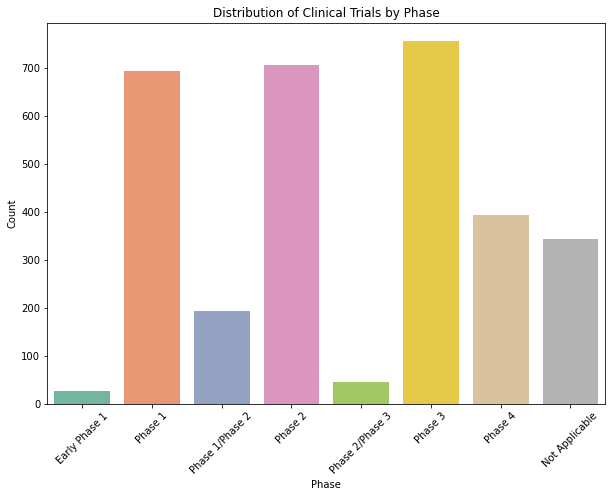

In [744]:
# Plot the distribution of clinical trials by phase

# Select only 'nct_id' and 'phase' columns
phase_df = vax_trials[['nct_id', 'phase']]
phase_df = phase_df.drop_duplicates()


# Define the order for phases
phase_order = ['Early Phase 1', 'Phase 1', 'Phase 1/Phase 2', 'Phase 2', 'Phase 2/Phase 3', 'Phase 3', 'Phase 4', 'Not Applicable']


# Set the figure size
plt.figure(figsize=(10, 7))

# Plot a countplot
sns.countplot(x='phase', data=phase_df, palette='Set2', order=phase_order)
plt.title('Distribution of Clinical Trials by Phase')
plt.xlabel('Phase')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

##### Identify the most frequently reported reasons for patients discontinuing their participation in clinical trials related to vaccine interventions.

In [745]:
# Utilize the 'sum_count' function to extract the 'reason_dropout' and 'count_dropout' columns from the dataframe
# and sum the values in the 'count_dropout' column

reason_sum = sum_count(vax_trials_with_dropouts, 'reason_dropout', 'count_dropout')
reason_sum.head()

,reason_dropout,TotalSum
0,6-month contact; withdraw before vax 2,123.0
1,administrative reason,724.0
2,adverse event,6466.0
3,ae or death,56.0
4,alternative therapy,3.0


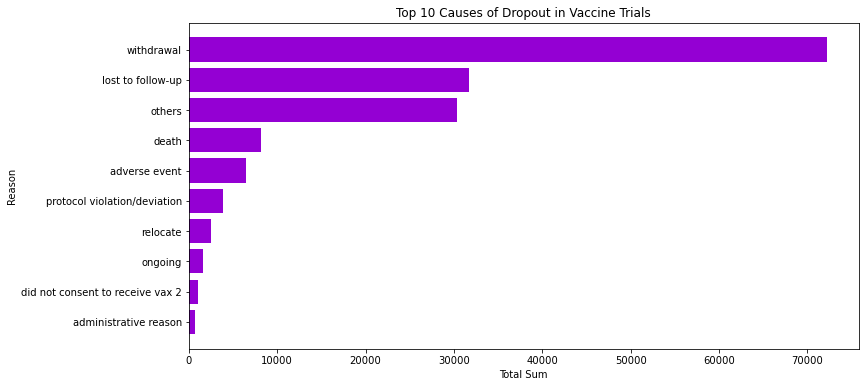

In [746]:
# Plot
dataframe = reason_sum
x_column = 'reason_dropout'
y_column = 'TotalSum'
title = 'Top 10 Causes of Dropout in Vaccine Trials'
xlabel = 'Total Sum'
ylabel = 'Reason'

plot_top_10_sum(dataframe, x_column, y_column, title, xlabel, ylabel)


##### Determine the most prevalent conditions in vaccine clinical trials

In [747]:
# Utilize the 'total_count' function to extract the 'nct_id' and 'condition_name' columns from the dataframe
# and compute the total count of unique conditions present in the 'condition_name' column.


condition_counts = total_count(vax_trials, 'nct_id', 'condition_name')
condition_counts.head()

,condition_name,TotalCount
0,influenza,775
1,meningococcal,163
2,sars-cov-2,153
3,hiv,147
4,pneumococcal,121


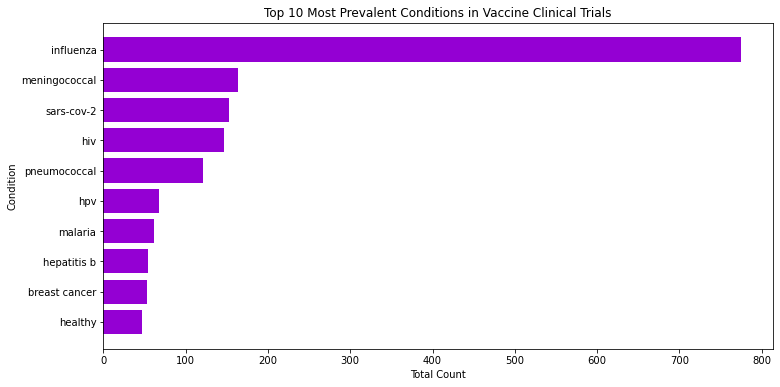

In [748]:
# Plot

dataframe = condition_counts
x_column = 'condition_name'
y_column = 'TotalCount'
title = 'Top 10 Most Prevalent Conditions in Vaccine Clinical Trials'
xlabel = 'Total Count'
ylabel = 'Condition'

plot_top_10_count(dataframe, x_column, y_column, title, xlabel, ylabel)

##### Determine the prevalence of vaccines utilized as interventions in clinical trials 

In [749]:
# Utilize the 'total_count' function to extract the 'nct_id' and 'vaccine_name' columns from the dataframe
# and compute the total count of unique vaccines present in the 'vaccine_name' column.

interventions_count = total_count(vax_trials, 'nct_id', 'vaccine_name')
interventions_count.head()

,vaccine_name,TotalCount
0,influenza vaccine,37
1,rabies vaccine,19
2,hepatitis b vaccine,17
3,pfspz vaccine,17
4,13-valent pneumococcal conjugate vaccine,15


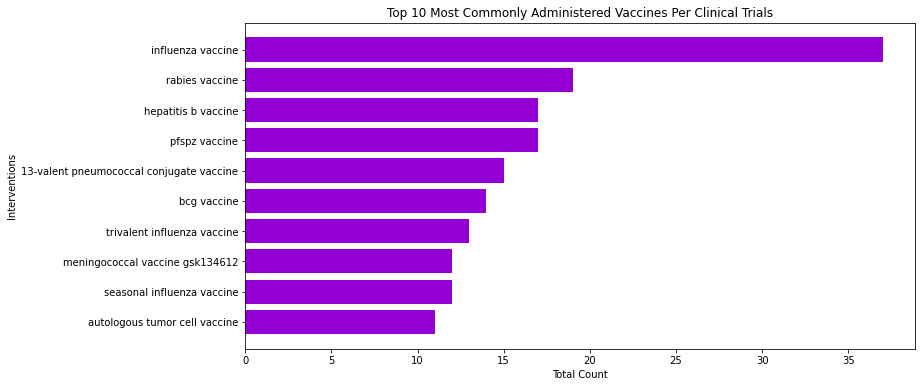

In [750]:
# Plot
dataframe = interventions_count
x_column = 'vaccine_name'
y_column = 'TotalCount'
title = 'Top 10 Most Commonly Administered Vaccines Per Clinical Trials'
xlabel = 'Total Count'
ylabel = 'Interventions'

plot_top_10_count(dataframe, x_column, y_column, title, xlabel, ylabel)

##### Summary of participants' progress in the study, including the count of those who started and completed the trial.

In [751]:
# use the 'sum_count' function to select the 'Status' and 'Count' columns and sum the values in the 'Count' column

progress_sum = sum_count(vax_trials_with_milestones, 'participant_progress', 'participants_number')
progress_sum.head()

,participant_progress,TotalSum
0,1 year visit,254.0
1,1- month post-op,13.0
2,15-day follow-up,146.0
3,3 month follow-up,143.0
4,3-6 months post-op,12.0


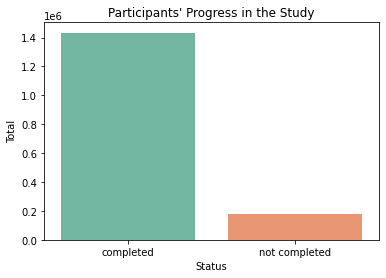

In [752]:
# Filter rows where the 'Title' column is either 'completed' or 'not completed'
progress_filtered = progress_sum[progress_sum['participant_progress'].isin(['completed', 'not completed'])]

# Plot a barplot
sns.barplot(x='participant_progress', y='TotalSum', data=progress_filtered, palette='Set2')
plt.title('Participants\' Progress in the Study')
plt.xlabel('Status')
plt.ylabel('Total')
plt.show()


##### Identify the most prevalent adverse events in vaccine clinical trials

In [753]:
ae_sum = sum_count(vax_trials_with_ae, 'adverse_event_term', 'subjects_affected')
ae_sum = ae_sum.sort_values(by='TotalSum', ascending=False)
ae_sum.head()

,adverse_event_term,TotalSum
4068,injection site pain,139608.0
3291,headache,125140.0
4316,irritability,124682.0
6634,pyrexia,124237.0
5755,pain,124112.0


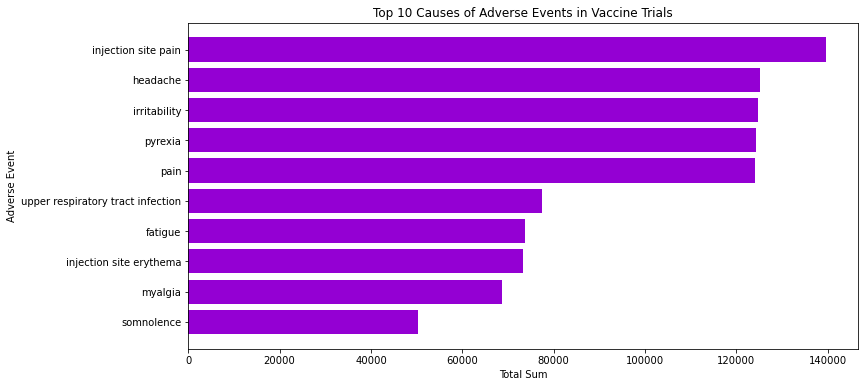

In [754]:
# Plot
dataframe = ae_sum
x_column = 'adverse_event_term'
y_column = 'TotalSum'
title = 'Top 10 Causes of Adverse Events in Vaccine Trials'
xlabel = 'Total Sum'
ylabel = 'Adverse Event'

plot_top_10_sum(dataframe, x_column, y_column, title, xlabel, ylabel)

##### Summary of participants' types of adverse events, whether serious or not.

In [755]:
event_sum = sum_count(vax_trials_with_ae, 'event_type', 'subjects_affected')
event_sum = event_sum.sort_values(by='TotalSum', ascending=False)
event_sum.head()

,event_type,TotalSum
0,other,2021127.0
1,serious,395498.0


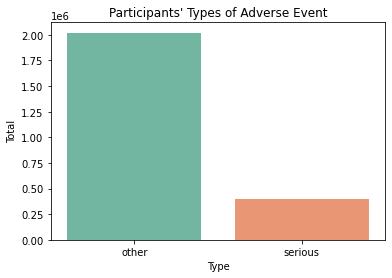

In [756]:
# Plot a barplot
sns.barplot(x='event_type', y='TotalSum', data=event_sum, palette='Set2')
plt.title('Participants\' Types of Adverse Event')
plt.xlabel('Type')
plt.ylabel('Total')
plt.show()

### Preprocessing the Data for Machine Learning Models

1. **Handle Missing Values:**
   - Identify and address missing values using techniques such as imputation or removal.

2. **Data Cleaning:**
   - Remove duplicate records if applicable.

3. **Data Encoding:**
   - Encode categorical variables into numerical representations using techniques like one-hot encoding or label encoding.

4. **Normalization and Scaling:**
   - Normalize or scale numerical features to ensure uniformity and improve model performance.
   - Techniques include Min-Max scaling or Standardization.

5. **Feature Selection Methods**
    - Techniques include: filter, wrapper, and embedded methods.

5. **Data Splitting:**
   - Split the dataset into training and testing sets for machine learning models.


- Data aggregation: dropout

In [757]:
# Filter out 'started' status
vax_trials_with_milestones = vax_trials_with_milestones[vax_trials_with_milestones['participant_progress'] != 'started']

# Aggregate p'articipant_progress' counts at the clinical trial level
completed_counts = vax_trials_with_milestones[vax_trials_with_milestones['participant_progress'] == 'completed'].groupby('nct_id')['participants_number'].sum()
not_completed_counts = vax_trials_with_milestones[vax_trials_with_milestones['participant_progress'] == 'not completed'].groupby('nct_id')['participants_number'].sum()

# Merge aggregated counts
aggregated_milestones = pd.merge(completed_counts, not_completed_counts, on='nct_id', how='outer', suffixes=('_completed', '_not_completed'))

In [758]:
# Create binary target column indicating whether there are any dropouts for each clinical trial
# 0: no dropouts, 1: at least one dropout
aggregated_milestones['dropout'] = (aggregated_milestones['participants_number_not_completed'] > 0).astype(int)
aggregated_milestones.reset_index(inplace=True)
aggregated_milestones.head()

,nct_id,participants_number_completed,participants_number_not_completed,dropout
0,NCT00003222,40.0,1.0,1
1,NCT00005780,49.0,1.0,1
2,NCT00006184,19.0,1.0,1
3,NCT00030823,13.0,1.0,1
4,NCT00053482,357.0,0.0,0


In [759]:
# Count the occurrences of 0s and 1s in the 'dropout' column
dropout_counts = aggregated_milestones['dropout'].value_counts()

# Display the counts
print(dropout_counts)


1    940
0    166
Name: dropout, dtype: int64


- Data aggregation: adverse events

In [760]:
# Aggregate status counts at the clinical trial level
serious_counts = vax_trials_with_ae[vax_trials_with_ae['event_type'] == 'serious'].groupby('nct_id')['subjects_affected'].sum()
other_counts = vax_trials_with_ae[vax_trials_with_ae['event_type'] == 'other'].groupby('nct_id')['subjects_affected'].sum()

# Merge aggregated counts
aggregated_event_type = pd.merge(serious_counts, other_counts, on='nct_id', how='outer', suffixes=('_serious', '_other'))

# Reset index
aggregated_event_type.reset_index(inplace=True)

# Display df
aggregated_event_type.head()

,nct_id,subjects_affected_serious,subjects_affected_other
0,NCT00003222,60.0,396.0
1,NCT00005780,57.0,597.0
2,NCT00006184,138.0,436.0
3,NCT00030823,2.0,33.0
4,NCT00053482,2.0,1412.0


In [761]:
# Rename columns
aggregated_event_type = aggregated_event_type.rename(columns={'subjects_affected_serious':'AE_total_serious', 'subjects_affected_other':'AE_total_other'})
aggregated_event_type.head()

,nct_id,AE_total_serious,AE_total_other
0,NCT00003222,60.0,396.0
1,NCT00005780,57.0,597.0
2,NCT00006184,138.0,436.0
3,NCT00030823,2.0,33.0
4,NCT00053482,2.0,1412.0


- Data encoding: 

    - clinical trial phase
    - gender

In [762]:
# Define mapping for phase categories to numerical values
phase_mapping = {
    'Early Phase 1': 1,
    'Phase 1': 2,
    'Phase 1/Phase 2': 3,
    'Phase 2': 4,
    'Phase 2/Phase 3': 5,
    'Phase 3': 6,
    'Phase 4': 7,
    'Not Applicable': 0
}

# Map the 'phase' column to numerical values
vax_trials['phase_encoded'] = vax_trials['phase'].map(phase_mapping)

# Display df
vax_trials.head()

,nct_id,overall_status,phase,enrollment,vaccine_name,condition_name,actual_duration,gender,mean_age,phase_encoded
0,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,6
1,NCT00996138,Completed,Phase 2/Phase 3,200.0,"adjuvanted cell-derived, inactivated novel swi...",influenza,2.0,All,44.5,5
2,NCT01003314,Completed,Phase 1/Phase 2,16.0,adch63-msp1 (lower dose) vaccine and mva-msp1 ...,malaria,10.0,All,34.0,3
3,NCT00488826,Completed,Phase 1,800.0,"7-valent pneumococcal conjugate vaccine, dipth...",pneumococcal,NaN,All,NaN,2
4,NCT03763565,Completed,Not Applicable,993.0,bivalent or quadrivalent hpv vaccines,hpv,8.0,Female,39.0,0


In [763]:
# Initialize the LabelEncoder
le = LabelEncoder()

# Encode the 'gender' column
vax_trials['gender_encoded'] = le.fit_transform(vax_trials['gender'])

# Display the DataFrame with the new column
vax_trials.head()

,nct_id,overall_status,phase,enrollment,vaccine_name,condition_name,actual_duration,gender,mean_age,phase_encoded,gender_encoded
0,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,6,0
1,NCT00996138,Completed,Phase 2/Phase 3,200.0,"adjuvanted cell-derived, inactivated novel swi...",influenza,2.0,All,44.5,5,0
2,NCT01003314,Completed,Phase 1/Phase 2,16.0,adch63-msp1 (lower dose) vaccine and mva-msp1 ...,malaria,10.0,All,34.0,3,0
3,NCT00488826,Completed,Phase 1,800.0,"7-valent pneumococcal conjugate vaccine, dipth...",pneumococcal,NaN,All,NaN,2,0
4,NCT03763565,Completed,Not Applicable,993.0,bivalent or quadrivalent hpv vaccines,hpv,8.0,Female,39.0,0,1


Data integration

- merge 'vax_trials' with 'aggregated_milestones'

In [764]:
df_ml = pd.merge(vax_trials, aggregated_milestones, on='nct_id')
df_ml.head()

,nct_id,overall_status,phase,enrollment,vaccine_name,condition_name,actual_duration,gender,mean_age,phase_encoded,gender_encoded,participants_number_completed,participants_number_not_completed,dropout
0,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,17.5,6,0,436.0,14.0,1
1,NCT00488826,Completed,Phase 1,800.0,"7-valent pneumococcal conjugate vaccine, dipth...",pneumococcal,NaN,All,NaN,2,0,666.0,134.0,1
2,NCT00623831,Completed,Phase 1,17.0,mixed bacterial vaccine,prostate cancer,60.0,All,NaN,2,0,15.0,2.0,1
3,NCT00434577,Completed,Phase 2,715.0,"herpes zoster vaccine gsk1437173a low dose, he...",herpes zoster,7.0,All,NaN,4,0,2697.0,13.0,1
4,NCT00616421,Completed,Phase 3,2907.0,licensed meningococcal acwy vaccine,meningococcal,13.0,All,6.0,6,0,2802.0,105.0,1


In [765]:
# Calculate dropout rates as a percentage
df_ml['dropout_rate'] = (df_ml['participants_number_not_completed'] / df_ml['enrollment']) * 100

In [766]:
# Count the number of missing values in each column
na_counts = df_ml.isna().sum()
print(na_counts)

nct_id                                 0
overall_status                         0
phase                                  0
enrollment                             0
vaccine_name                           0
condition_name                         0
actual_duration                        3
gender                                 0
mean_age                             616
phase_encoded                          0
gender_encoded                         0
participants_number_completed          0
participants_number_not_completed      0
dropout                                0
dropout_rate                           0
dtype: int64


In [767]:
# Drop 'mean_age'
df_ml.drop(columns=['mean_age'], axis=1, inplace=True)

In [768]:
# Drop NA
df_ml = df_ml.dropna()

Data integration

- merge 'df_ml' with 'aggregated_event_types'

In [769]:
df_ml = pd.merge(df_ml, aggregated_event_type, on='nct_id')
df_ml.head()

,nct_id,overall_status,phase,enrollment,vaccine_name,condition_name,actual_duration,gender,phase_encoded,gender_encoded,participants_number_completed,participants_number_not_completed,dropout,dropout_rate,AE_total_serious,AE_total_other
0,NCT00444951,Completed,Phase 3,450.0,"menactra®: meningococcal a, c, y, and w 135 po...",meningococcal,12.0,All,6,0,436.0,14.0,1,3.111111,1.0,1082.0
1,NCT00623831,Completed,Phase 1,17.0,mixed bacterial vaccine,prostate cancer,60.0,All,2,0,15.0,2.0,1,11.764706,3.0,100.0
2,NCT00434577,Completed,Phase 2,715.0,"herpes zoster vaccine gsk1437173a low dose, he...",herpes zoster,7.0,All,4,0,2697.0,13.0,1,1.818182,349.0,1716.0
3,NCT00616421,Completed,Phase 3,2907.0,licensed meningococcal acwy vaccine,meningococcal,13.0,All,6,0,2802.0,105.0,1,3.611971,119.0,4625.0
4,NCT04515147,Completed,Phase 2,668.0,"hepatitis a vaccine, pneumococcal vaccine",sars-cov-2,17.0,All,4,0,611.0,57.0,1,8.532934,140.0,3398.0


In [770]:
# Count the number of missing values in each column
na_counts = df_ml.isna().sum()
print(na_counts)

nct_id                                 0
overall_status                         0
phase                                  0
enrollment                             0
vaccine_name                           0
condition_name                         0
actual_duration                        0
gender                                 0
phase_encoded                          0
gender_encoded                         0
participants_number_completed          0
participants_number_not_completed      0
dropout                                0
dropout_rate                           0
AE_total_serious                     215
AE_total_other                        36
dtype: int64


In [771]:
# Fill NaN values with 0
df_ml = df_ml.fillna(0)

In [772]:
# Check for duplicates
duplicates = df_ml.duplicated()
print(duplicates.value_counts())

False    1039
dtype: int64


In [773]:
# Drop columns
df_ml = df_ml.drop(columns=['overall_status', 'phase', 'gender', 'vaccine_name', 'participants_number_completed', 'participants_number_not_completed'])
df_ml.head()

,nct_id,enrollment,condition_name,actual_duration,phase_encoded,gender_encoded,dropout,dropout_rate,AE_total_serious,AE_total_other
0,NCT00444951,450.0,meningococcal,12.0,6,0,1,3.111111,1.0,1082.0
1,NCT00623831,17.0,prostate cancer,60.0,2,0,1,11.764706,3.0,100.0
2,NCT00434577,715.0,herpes zoster,7.0,4,0,1,1.818182,349.0,1716.0
3,NCT00616421,2907.0,meningococcal,13.0,6,0,1,3.611971,119.0,4625.0
4,NCT04515147,668.0,sars-cov-2,17.0,4,0,1,8.532934,140.0,3398.0


- Groupping 'condition_name'

    - infectious diseases;
    - cancer;
    - inflammatory diseases;
    - autoimmune diseases;
    - congenital disorders;
    - allergy;
    - chronic diseases;
    - transplant;
    - respiratory disorders;
    - heart diseases.


In [774]:
# Define the mapping dictionary
mapping = {
    'influenza':'infectious diseases',
    'sars-cov-2':'infectious diseases',
    'dengue':'infectious diseases',
    'hand':'infectious diseases',
    'hpv':'infectious diseases',
    'hiv':'infectious diseases',
    'meningococcal':'infectious diseases',
    'pneumococcal':'infectious diseases',
    'streptococcal':'infectious diseases',
    'inflammatory bowel disease':'inflammatory diseases',
    'cancer':'cancer',
    'malaria':'infectious diseases',
    'herpes zoster':'infectious diseases',
    'virus':'infectious diseases',
    'bacteria':'infectious diseases',
    'carcinomatosis':'cancer',
    'carcinoma':'cancer',
    'smallpox':'infectious diseases',
    'sarcoma':'cancer',
    'leukemia':'cancer',
    'neoplasm':'cancer',
    'hepatitis b':'infectious diseases',
    'poliomyelitis':'infectious diseases',
    'hepatitis':'infectious diseases',
    'tuberculosis':'infectious diseases',
    'rabies':'infectious diseases',
    'melanoma':'cancer',
    'yeast infections':'infectious diseases',
    'tumors':'cancer',
    'candidiasis':'infectious diseases',
    'streptococcus':'infectious diseases',
    'congenital':'congenital disorders',
    'chikungunya':'infectious diseases',
    'rubella':'infectious diseases',
    'varicella':'infectious diseases',
    'mumps':'infectious diseases',
    'measles':'infectious diseases',
    'herpes':'infectious diseases',
    'meningitidis':'infectious diseases',
    'cholera':'infectious diseases',
    'pertussis':'infectious diseases',
    'infectious diseases':'infectious diseases',
    'lymphoma':'cancer',
    'glioma':'cancer',
    'aids':'infectious diseases',
    'yellow fever':'infectious diseases',
    'bacillary':'infectious diseases',
    'mers':'infectious diseases',
    'viral':'infectious diseases',
    'polio':'infectious diseases',
    'infections':'infectious diseases',
    'clostridium':'infectious diseases',
    'ebola':'infectious diseases',
    'healthy':'healthy',
    'allergy':'allergy',
    'meningitis':'infectious diseases',
    'pregnancy':'pregnancy',
    'gastroenteritis':'infectious diseases',
    'bronchiolitis':'infectious diseases',
    'squamous intraepithelial lesion':'cancer',
    'dermatitis':'inflammatory diseases',
    'multiple sclerosis':'autoimmune diseases',
    'typhoid':'infectious diseases',
    'japanese encephalitis':'infectious diseases',
    'encephalitis':'infectious diseases',
    'shigella':'infectious diseases',
    'glioblastoma':'cancer',
    'myeloma':'cancer',
    'rheumatoid arthritis':'autoimmune diseases',
    'arthritis, rheumatoid':'autoimmune diseases',
    'chronic':'chronic diseases',
    'shigellosis':'infectious diseases',
    'diphtheria':'infectious diseases', 
    'tetanus':'infectious diseases',
    'infection':'infectious diseases', 
    'asthma':'chronic diseases',
    'transplant':'transplant',
    'condylomata acuminata':'infectious diseases',
    'neoplasia':'cancer',
    'allergic':'allergy',
    'west nile fever':'infectious diseases',
    'tularemia':'infectious diseases',
    'q fever':'infectious diseases',
    'efficacy of the new cprv':'infectious diseases',
    'toxic shock syndrome':'infectious diseases',
    'heart':'heart diseases',
    'shingles':'infectious diseases',
    'end stage renal disease':'chronic diseases',
    'sepsis':'infectious diseases',
    'hemorrhagic fever with renal syndrome':'infectious diseases',
    'rift valley fever':'infectious diseases',  
    
}

# Loop through the mapping dictionary and apply replacements
for old_value, new_value in mapping.items():
    df_ml.loc[df_ml['condition_name'].str.contains(old_value), 'condition_name'] = new_value

In [775]:
df_ml.head()

,nct_id,enrollment,condition_name,actual_duration,phase_encoded,gender_encoded,dropout,dropout_rate,AE_total_serious,AE_total_other
0,NCT00444951,450.0,infectious diseases,12.0,6,0,1,3.111111,1.0,1082.0
1,NCT00623831,17.0,cancer,60.0,2,0,1,11.764706,3.0,100.0
2,NCT00434577,715.0,infectious diseases,7.0,4,0,1,1.818182,349.0,1716.0
3,NCT00616421,2907.0,infectious diseases,13.0,6,0,1,3.611971,119.0,4625.0
4,NCT04515147,668.0,infectious diseases,17.0,4,0,1,8.532934,140.0,3398.0


In [776]:
values_to_drop = [
    'vaccine response impaired',
    'vomiting, diarrhea, fever',
    'prospective, single-blind, clinical, trial, intervention',
    'innate immune response',
    'diarrhea',
    'safety, adverse event following immunisation, birth outcomes',
    'vaccine',
    'pregnancy',
    'nicotine dependence',
    'non-target heterologous effects of vaccines, vaccine interactions',
    'dose schedule study',
    'healthy',
    'short bowel syndrome'
]

# Drop rows containing the specified values in the column
df_ml = df_ml[~df_ml['condition_name'].isin(values_to_drop)]

# Print the filtered DataFrame
df_ml.head()

,nct_id,enrollment,condition_name,actual_duration,phase_encoded,gender_encoded,dropout,dropout_rate,AE_total_serious,AE_total_other
0,NCT00444951,450.0,infectious diseases,12.0,6,0,1,3.111111,1.0,1082.0
1,NCT00623831,17.0,cancer,60.0,2,0,1,11.764706,3.0,100.0
2,NCT00434577,715.0,infectious diseases,7.0,4,0,1,1.818182,349.0,1716.0
3,NCT00616421,2907.0,infectious diseases,13.0,6,0,1,3.611971,119.0,4625.0
4,NCT04515147,668.0,infectious diseases,17.0,4,0,1,8.532934,140.0,3398.0


In [777]:
# Print the unique disease names
unique_diseases = df_ml['condition_name'].unique()
print(unique_diseases)

['infectious diseases' 'cancer' 'inflammatory diseases'
 'autoimmune diseases' 'congenital disorders' 'allergy' 'chronic diseases'
 'transplant' 'respiratory disorders' 'heart diseases']


In [778]:
# Count the occurrences of 0s and 1s in the 'dropout' column
dropout_counts = df_ml['dropout'].value_counts()

# Display the counts
print(dropout_counts)

1    877
0    132
Name: dropout, dtype: int64


Filter methods

- Variance threshold: to remove any features that have little to no variation in their values.
- Pearson’s correlation: measuring the linear relationship between two numeric, continuous variables. Correlation between features, and correlation between features and target.
- F-statistic: correlation between features and target.
- Mutual information: measures the dependence between two variables and can be used to estimate how much a feature contributes to the prediction of the target variable.


In [779]:
# features
features = df_ml.drop(['nct_id', 'condition_name', 'phase_encoded', 'gender_encoded', 'dropout', 'dropout_rate'], axis=1)

# target variable
target = df_ml['dropout_rate']

In [780]:
# Variance threshold
selector = VarianceThreshold(threshold=0)  # 0 is default
print(selector.fit_transform(features))

[[4.500e+02 1.200e+01 1.000e+00 1.082e+03]
 [1.700e+01 6.000e+01 3.000e+00 1.000e+02]
 [7.150e+02 7.000e+00 3.490e+02 1.716e+03]
 ...
 [3.000e+02 7.000e+00 3.000e+00 4.200e+01]
 [1.447e+03 1.200e+01 9.300e+01 5.699e+03]
 [4.800e+01 3.000e+00 6.000e+00 2.480e+02]]


In [781]:
# Use indices to get the corresponding column names of selected features
num_cols = list(features.columns[selector.get_support(indices=True)])
print(num_cols)

['enrollment', 'actual_duration', 'AE_total_serious', 'AE_total_other']


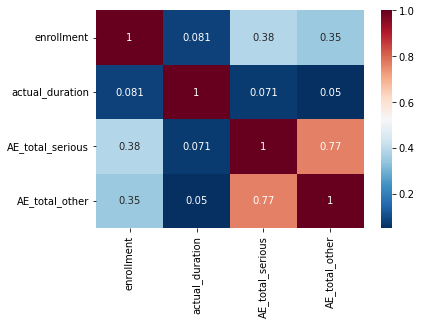

In [782]:
# Pearson’s correlation: 
# Correlation between features: drop highly correlated features to avoid duplicate information.

corr_matrix = features.corr(method='pearson') 

sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r')
plt.show()

In [783]:
# Correlation between features and target

X_y = features.copy()
X_y['dropout_rate'] = target

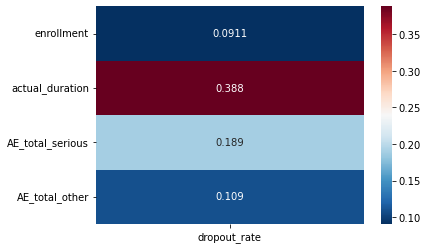

In [784]:
corr_matrix = X_y.corr()

# Isolate the column corresponding to 'dropout'
corr_target = corr_matrix[['dropout_rate']].drop(labels=['dropout_rate'])

sns.heatmap(corr_target, annot=True, fmt='.3', cmap='RdBu_r')
plt.show()

In [785]:
# F-statistic: correlation between features and target
# The F-statistic will be larger (and p-value will be smaller) for predictors that are more highly correlated with the target variable
# First array: F-statistic
# Second array: p-value

print(f_regression(features, target))

(array([  8.4205699 , 178.17908911,  37.39132538,  12.09662295]), array([3.79080586e-03, 1.52927633e-37, 1.38085149e-09, 5.26727886e-04]))


In [786]:
# Mutual information

# features
features = df_ml.drop(['nct_id', 'condition_name', 'dropout', 'dropout_rate'], axis=1)

# target variable
target = df_ml['dropout_rate']

print(mutual_info_regression(features, target, discrete_features=[2,3], random_state=68))

[0.20818195 0.17483381 0.02003992 0.03389111 0.0972512  0.0655195 ]


In [787]:
score_func = partial(mutual_info_regression, discrete_features=[2,3], random_state=68)

# Select top 3 features with the most mutual information
selection = SelectKBest(score_func=score_func, k=3)

print(selection.fit_transform(features, target))

[[4.500e+02 1.200e+01 1.000e+00]
 [1.700e+01 6.000e+01 3.000e+00]
 [7.150e+02 7.000e+00 3.490e+02]
 ...
 [3.000e+02 7.000e+00 3.000e+00]
 [1.447e+03 1.200e+01 9.300e+01]
 [4.800e+01 3.000e+00 6.000e+00]]


In [788]:
X = features[features.columns[selection.get_support(indices=True)]]
print(X)

      enrollment  actual_duration  AE_total_serious
0          450.0             12.0               1.0
1           17.0             60.0               3.0
2          715.0              7.0             349.0
3         2907.0             13.0             119.0
4          668.0             17.0             140.0
...          ...              ...               ...
1034       406.0             19.0               0.0
1035        50.0             56.0              38.0
1036       300.0              7.0               3.0
1037      1447.0             12.0              93.0
1038        48.0              3.0               6.0

[1009 rows x 3 columns]


One-Hot Encoding:

- dummy variables are created to handle categorical variables. They transform each category within a variable into its own binary identifier.
- disadvantage: it can lead to a high-dimensional feature space if there are many unique diseases, so it may not be efficient for large datasets.

In [789]:
# Create dummy variables for 'condition_name' 
df_ml_one_hot = pd.get_dummies(df_ml, columns=['condition_name'], prefix=['condition'])
df_ml_one_hot.head()

,nct_id,enrollment,actual_duration,phase_encoded,gender_encoded,dropout,dropout_rate,AE_total_serious,AE_total_other,condition_allergy,condition_autoimmune diseases,condition_cancer,condition_chronic diseases,condition_congenital disorders,condition_heart diseases,condition_infectious diseases,condition_inflammatory diseases,condition_respiratory disorders,condition_transplant
0,NCT00444951,450.0,12.0,6,0,1,3.111111,1.0,1082.0,0,0,0,0,0,0,1,0,0,0
1,NCT00623831,17.0,60.0,2,0,1,11.764706,3.0,100.0,0,0,1,0,0,0,0,0,0,0
2,NCT00434577,715.0,7.0,4,0,1,1.818182,349.0,1716.0,0,0,0,0,0,0,1,0,0,0
3,NCT00616421,2907.0,13.0,6,0,1,3.611971,119.0,4625.0,0,0,0,0,0,0,1,0,0,0
4,NCT04515147,668.0,17.0,4,0,1,8.532934,140.0,3398.0,0,0,0,0,0,0,1,0,0,0


Frequency Encoding:

- replace each disease category ('condition_name') with the frequency of its occurrence in the dataset.
- this transformation captures the information about how common each disease is in the dataset.

In [790]:
# Calculate frequency of occurrence for each disease category
disease_frequency = df_ml['condition_name'].value_counts(normalize=True)

# Map the frequency of occurrence to each disease category
df_ml['disease_frequency_encoded'] = df_ml['condition_name'].map(disease_frequency)

# Display df
df_ml.head()


,nct_id,enrollment,condition_name,actual_duration,phase_encoded,gender_encoded,dropout,dropout_rate,AE_total_serious,AE_total_other,disease_frequency_encoded
0,NCT00444951,450.0,infectious diseases,12.0,6,0,1,3.111111,1.0,1082.0,0.855302
1,NCT00623831,17.0,cancer,60.0,2,0,1,11.764706,3.0,100.0,0.111992
2,NCT00434577,715.0,infectious diseases,7.0,4,0,1,1.818182,349.0,1716.0,0.855302
3,NCT00616421,2907.0,infectious diseases,13.0,6,0,1,3.611971,119.0,4625.0,0.855302
4,NCT04515147,668.0,infectious diseases,17.0,4,0,1,8.532934,140.0,3398.0,0.855302


Label Encoding: condititon name.

In [791]:
# Initialize the LabelEncoder
le = LabelEncoder()

# Encode the 'condition_name' column
df_ml['condition_encoded'] = le.fit_transform(df_ml['condition_name'])

# Display the DataFrame with the new column
df_ml.head()

,nct_id,enrollment,condition_name,actual_duration,phase_encoded,gender_encoded,dropout,dropout_rate,AE_total_serious,AE_total_other,disease_frequency_encoded,condition_encoded
0,NCT00444951,450.0,infectious diseases,12.0,6,0,1,3.111111,1.0,1082.0,0.855302,6
1,NCT00623831,17.0,cancer,60.0,2,0,1,11.764706,3.0,100.0,0.111992,2
2,NCT00434577,715.0,infectious diseases,7.0,4,0,1,1.818182,349.0,1716.0,0.855302,6
3,NCT00616421,2907.0,infectious diseases,13.0,6,0,1,3.611971,119.0,4625.0,0.855302,6
4,NCT04515147,668.0,infectious diseases,17.0,4,0,1,8.532934,140.0,3398.0,0.855302,6


Data normalization: 'enrollment', 'actual_duration', 'AE_total_serious', 'AE_total_other'
- min-max scaling

In [792]:
def min_max_scaling(df, columns):
    df_copy = df.copy()  # Create a copy of the original DataFrame
    for column in columns:
        min_val = df[column].min()
        max_val = df[column].max()
        new_column_name = column + '_scaled' 
        df_copy[new_column_name] = (df[column] - min_val) / (max_val - min_val)
    return df_copy  # Return the modified DataFrame

In [793]:
# Define a list of columns to be scaled
columns_to_scale = ['enrollment', 'actual_duration', 'AE_total_serious', 'AE_total_other']

# Call the function and assign the result to the original DataFrame
df_ml = min_max_scaling(df_ml, columns_to_scale)


In [794]:
# Display df
df_ml.head()

,nct_id,enrollment,condition_name,actual_duration,phase_encoded,gender_encoded,dropout,dropout_rate,AE_total_serious,AE_total_other,disease_frequency_encoded,condition_encoded,enrollment_scaled,actual_duration_scaled,AE_total_serious_scaled,AE_total_other_scaled
0,NCT00444951,450.0,infectious diseases,12.0,6,0,1,3.111111,1.0,1082.0,0.855302,6,0.005314,0.047059,0.000020,0.018450
1,NCT00623831,17.0,cancer,60.0,2,0,1,11.764706,3.0,100.0,0.111992,2,0.000189,0.235294,0.000059,0.001705
2,NCT00434577,715.0,infectious diseases,7.0,4,0,1,1.818182,349.0,1716.0,0.855302,6,0.008450,0.027451,0.006886,0.029261
3,NCT00616421,2907.0,infectious diseases,13.0,6,0,1,3.611971,119.0,4625.0,0.855302,6,0.034393,0.050980,0.002348,0.078864
4,NCT04515147,668.0,infectious diseases,17.0,4,0,1,8.532934,140.0,3398.0,0.855302,6,0.007894,0.066667,0.002762,0.057942


#### Select Variables

The data for the model will consist of a subset of variables. The **x** dataframe will contain features that could serve as good predictors for patient dropout in clinical trials. The **y** dataframe will include the target column, denoted by the 'dropout_rate', indicating the percentage of dropouts per clinical trial.

**Table 1.**

target variable: 

- dropout_rate

features:

- enrollment: total number of participants.
- condition_name: the grouped conditions were label encoded.
- actual_duration: total duration.
- phase_encoded: phase categories mapped to numerical values.
- AE_total_serious: total number of serious adverse events.
- AE_total_other: total number of other adverse events.


In [795]:
# Select variables
x = df_ml.drop(['nct_id', 'condition_name', 'gender_encoded', 'dropout', 'dropout_rate', 'disease_frequency_encoded', 'enrollment_scaled', 'actual_duration_scaled', 
                'AE_total_serious_scaled', 'AE_total_other_scaled'  ], axis=1)
y = df_ml['dropout_rate']


#### Splitting the Data

Next, the data needs to be divided into training and validation sets. In this split, 20% of the data is reserved for final validation, while 80% is allocated for training the model. 

In [796]:
# Splitting the data

#Validation chunk size
val_size = 0.20

#Split the data into chunks
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=val_size, random_state = 0)


#### Prediction

- **Model Building:** for this project, four algorithms will be used to make predictions:

  1. Linear Regression
  2. K Nearest Neighbor
  3. Decision Trees
  4. Random Forests

- **Evaluation Metrics:**
  - Mean Squared Error (MSE)
  - Mean Absolute Error (MAE)
  - R-squared (R2)

##### Multiple Linear Regression

In [797]:
# Initialize and train a linear regression model
lm = LinearRegression()
lm.fit(x_train, y_train)

# Make predictions on the test set
y_pred = lm.predict(x_test)

In [798]:
# Print coeficients and intercept
print("Coefficients of each feature:", lm.coef_)
print("Intercept:", lm.intercept_)

Coefficients of each feature: [ 1.44422431e-04  1.60161011e-01 -3.27331559e-01  1.42986424e-03
 -9.96924743e-05 -2.72092248e+00]
Intercept: 21.994316877126003


In [799]:
#Print train and test score
print("Train score:")
print(lm.score(x_train, y_train))

print("Test score:")
print(lm.score(x_test, y_test))

Train score:
0.22053380227686725
Test score:
0.20059118909044482


In [800]:
# Calculate the evaluation metrics to assess the model's performance

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

Mean Squared Error: 218.583385414353
Mean Absolute Error: 8.363348985308035
R-squared: 0.20059118909044482


##### K Nearest Neighbor


In [801]:
# Initialize the KNN regressor 
knn_regressor = KNeighborsRegressor(n_neighbors=5)

# Train the KNN regressor on the training data
knn_regressor.fit(x_train, y_train)

# Make predictions on the test data
y_pred = knn_regressor.predict(x_test)

In [802]:
# Calculate the evaluation metrics to assess the model's performance

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

Mean Squared Error: 211.55204052096386
Mean Absolute Error: 8.53953979110492
R-squared: 0.22630640550391556


##### Decision Trees


In [803]:
dt = DecisionTreeRegressor(max_depth=3)
dt.fit(x_train, y_train)
y_pred = dt.predict(x_test)
print(dt.score(x_test, y_test))

0.2873772256735142


In [804]:
# # Plot tree
# plt.figure(figsize=(10,10))
# tree.plot_tree(dt, feature_names = x_train.columns,  
#               filled=True)

##### Random Forests